In [85]:
import os
import time
from obspy import read, Stream, Trace
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

import joblib

In [2]:
def get_stream(network, station_code, location, channel, starttime, endtime):
    try:
        client = Client("IRIS")

        st = client.get_waveforms(network, station_code, location, channel, starttime, endtime)
    except Exception as e:
      print(f"Error fetching data for {network} {station_code}: {e}")
      st = None
    return st

In [3]:
def get_data(st):
    """Take a stream, fill gap with interpolate  and return  data"""
    st =  st.merge(method=1, fill_value='interpolate')
    tr = st[0]
    data = tr.data.astype(np.float32).reshape(-1, 1)
    return data

In [80]:
def prediction_output(window, model, look_back, batch_size):
    #reseting the state
    model.reset_states()
    
    # Normalise and  Reshape the initial window
    window = scale_data(window, scaler)
    window = np.reshape(window, (batch_size, look_back, 1))
    
    #Prediction
    predicted_value = model.predict(window, verbose = 0)  
    
    #Returning prediction to original format
    predictions = inverse_scaler(predicted_value, scaler)
    return predictions

In [5]:
def generate_predictions(window, model, look_back, num_iterations=1000):
    # Normalise and  Reshape the initial window
    window = scale_data(window, scaler)
    window = np.reshape(window, (1, look_back, 1))
    

    # Pre-allocate the array to store all windows
    all_windows = np.zeros((num_iterations, look_back, 1))

    # Fill the first window
    all_windows[0] = window

    # Initialize the predictions list
    predictions = []

    # Loop to add predicted values
    for i in range(0, num_iterations-1):
        predicted_value = model.predict(all_windows[i:i+1], verbose = 1)  # Example predicted value
        predictions.append(predicted_value[0])
        predicted_value = predicted_value.reshape(1, 1, 1)  # Ensure shape is (1, 1, 1)
        new_window = np.concatenate((all_windows[i:i+1], predicted_value), axis=1)
        all_windows[i+1] = new_window[:, -look_back:, :]  # Keep the last 100 elements

    predictions = inverse_scaler(predictions, scaler)
    return predictions

In [6]:
def fit_scaler(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = data.reshape(-1, 1)
    scaler.fit(data)
    return scaler

def scale_data(data, scaler):
    data = data.reshape(-1, 1)
    scaled_data = scaler.transform(data)
    return scaled_data

def inverse_scaler(scaled_data, scaler):
    restored_data = scaler.inverse_transform(scaled_data)
    return restored_data

In [76]:
def plot_seismogram(window, actual, predictions, look_back):
    fig = plt.figure(figsize=(10, 6))

    # Plot the window
    window_plot = window[-look_back:]
    plt.plot(window_plot, label='window')

    # Plot the actual data at the end of the window
    plt.plot(range(len(window_plot), len(window_plot) + len(actual)), actual, label='actual')

    # Plot the predictions at the end of the window
    plt.plot(range(len(window_plot), len(window_plot) + len(predictions[0])), predictions[0], label='predictions')

    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Seismogram Plot')
    plt.legend()
    plt.show()

In [56]:

#st = read("Data/MX_MOIG_BHZ_2023-01-01_2024-01-01.mseed")
#data = st[0].data
#scaler = fit_scaler(data)
#joblib.dump(scaler, 'scaler.save')

In [7]:
scaler = joblib.load('scaler.save')

In [59]:
starttime = UTCDateTime(2023, 6, 10)
endtime = starttime + timedelta(seconds=350)

network = "MX"
station_code = "MOIG"
channel = 'BHZ'
location = ""
client = Client("IRIS")

In [1]:
model = load_model('my_model_checkpoints/final_model_stateful_i2000_o600_b5_01.hdf5')

NameError: name 'load_model' is not defined

In [60]:
st = get_stream(network, station_code, location, channel, starttime, endtime)

In [61]:
st[0].stats

               network: MX
               station: MOIG
              location: 
               channel: BHZ
             starttime: 2023-06-10T00:00:00.015000Z
               endtime: 2023-06-10T00:05:49.965000Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 7000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 23, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 11776})
            processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2023, 6, 10, 0, 5, 50, 15000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2023, 6, 10, 0, 0, 0, 15000))']

In [32]:
data = get_data(st)

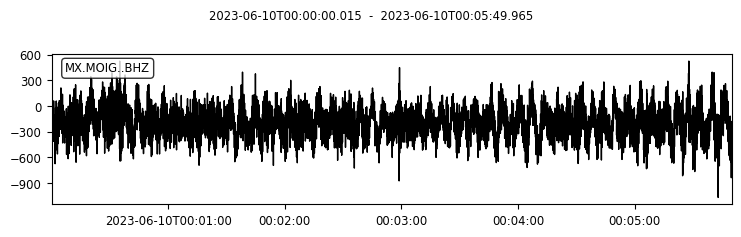

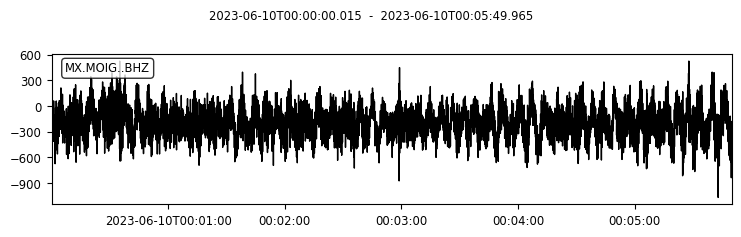

In [62]:
st.plot()

In [52]:
look_back = 1200
batch_size = 4
output = 600
window_range = look_back*batch_size
window = data[:window_range]
actual = data[window_range:window_range+output]
#prediction = generate_predictions(window, model, look_back, num_iterations=1)

In [81]:
def prepare_window(data, look_back, output, batch_size):
    window_range = look_back*batch_size
    window = data[:window_range]
    actual = data[window_range:window_range+output]
    return window, actual

def prepare_window_prediction(data, look_back, output, batch_size):
    window_range = look_back*batch_size
    window = data[-window_range:]
    return window

In [111]:
window, actual = prepare_window(data, look_back, output, batch_size)

In [65]:
predictions = prediction_output(window, model, look_back)

In [112]:
predictions.shape
#predictions[1]

(4, 600)

In [17]:
#window = np.reshape(window, (1, look_back, 1))
#predictions = model.predict(window)
#predictions = scaler.inverse_transform(predictions)
#predictions

In [19]:
predictions.reshape(1,-1)
predictions.shape

(1, 1000)

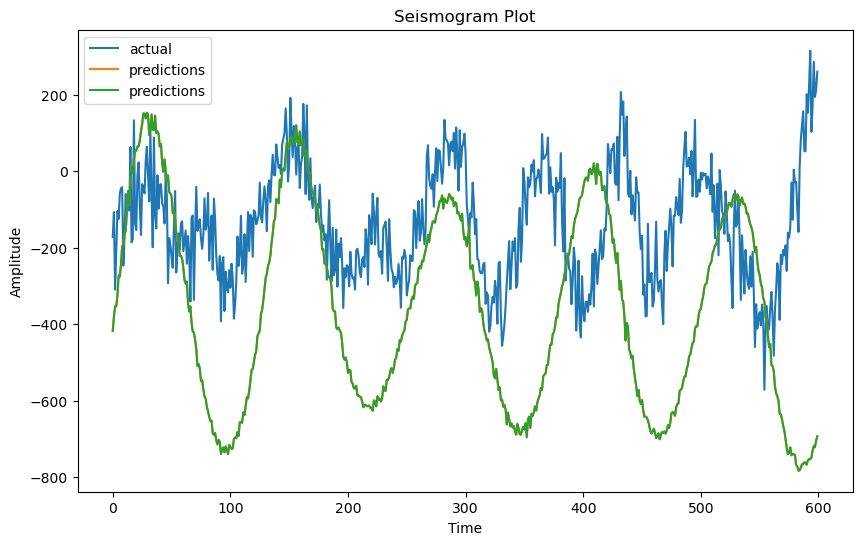

In [79]:
# Plot the seismogram using Matplotlib
fig = plt.figure(figsize=(10, 6))
#plt.plot(trace.times("matplotlib"), trace.data, label='Seismogram Data')
#plt.plot(window, label='window')
plt.plot(actual, label='actual')
plt.plot(predictions[0], label='predictions')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Seismogram Plot')
plt.legend()
plt.show()

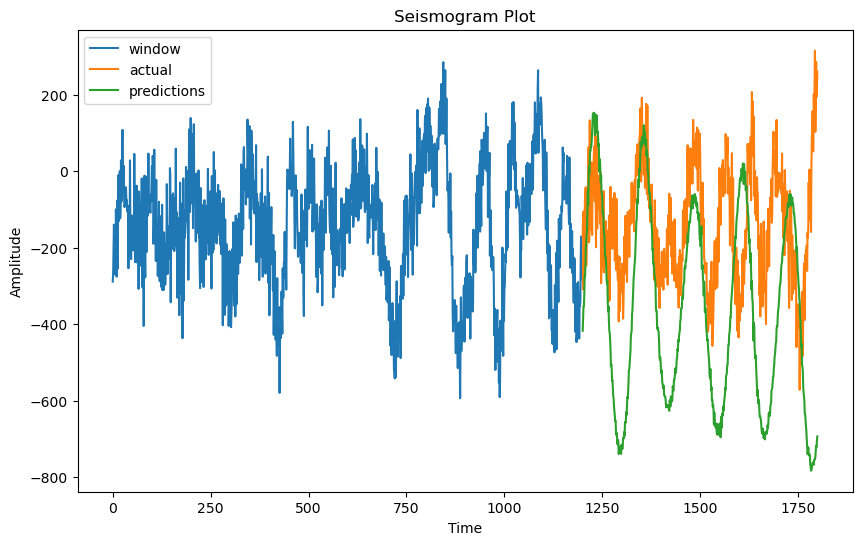

In [73]:
fig = plt.figure(figsize=(10, 6))

# Plot the window
window_plot = window[-look_back:]
plt.plot(window_plot, label='window')

# Plot the actual data at the end of the window
plt.plot(range(len(window_plot), len(window_plot) + len(actual)), actual, label='actual')

# Plot the predictions at the end of the window
plt.plot(range(len(window_plot), len(window_plot) + len(predictions[0])), predictions[0], label='predictions')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Seismogram Plot')
plt.legend()
plt.show()

In [74]:
def plot_seismogram(window, actual, predictions, look_back):
    fig = plt.figure(figsize=(10, 6))

    # Plot the window
    window_plot = window[-look_back:]
    plt.plot(window_plot, label='window')

    # Plot the actual data at the end of the window
    plt.plot(range(len(window_plot), len(window_plot) + len(actual)), actual, label='actual')

    # Plot the predictions at the end of the window
    plt.plot(range(len(window_plot), len(window_plot) + len(predictions[0])), predictions[0], label='predictions')

    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Seismogram Plot')
    plt.legend()
    plt.show()

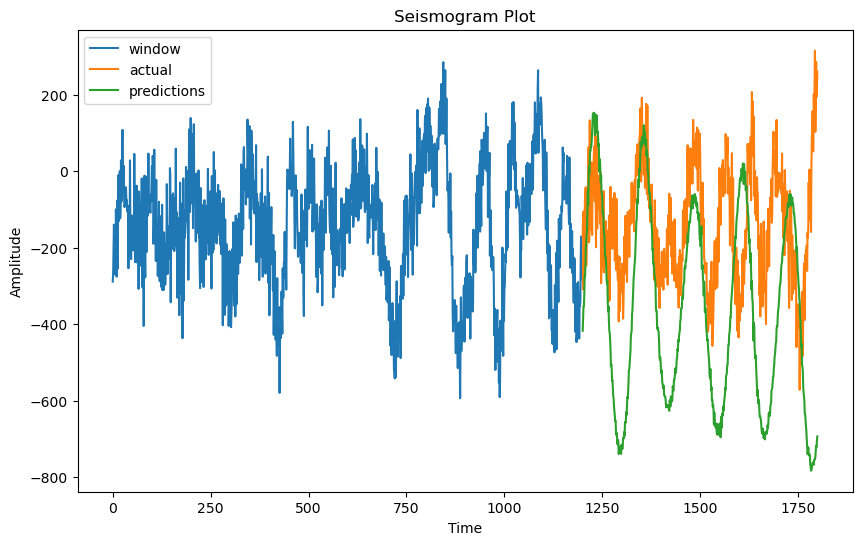

In [75]:
plot_seismogram(window, actual, predictions, look_back)

In [83]:
def update_data(look_back, batch_size):
    seconds = ((look_back * batch_size) / 10)
    endtime = UTCDateTime(datetime.utcnow())
    starttime = endtime - timedelta(seconds=seconds)
    
    st = get_stream(network, station_code, location, channel, starttime, endtime)
    trace = st[0]
    data = get_data(st)
    
    window = prepare_window_prediction(data, look_back, output, batch_size)
    predictions = prediction_output(window, model, look_back, batch_size)
    
    plot_prediction(trace, predictions)
    st.write("Data updated at:", time.strftime("%Y-%m-%d %H:%M:%S"))

In [110]:
update_data(look_back, batch_size)

ValueError: cannot reshape array of size 2258 into shape (4,1200,1)

In [100]:
seconds = ((look_back * batch_size) / 10)
endtime = UTCDateTime(datetime.utcnow())
starttime = endtime - timedelta(seconds=seconds)
    
st = get_stream(network, station_code, location, channel, starttime, endtime)
trace = st[0]
data = get_data(st)
len(data)

7482

In [89]:
trace.stats
seconds

240.0

In [93]:
endtime - starttime

240.0

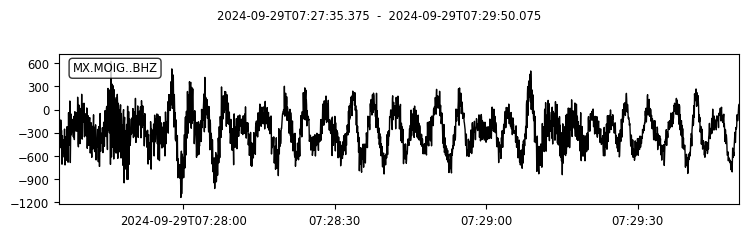

Source            Last Sample                 Next Sample                 Delta           Samples 
Total: 0 gap(s) and 0 overlap(s)


               network: MX
               station: MOIG
              location: 
               channel: BHZ
             starttime: 2024-09-29T07:27:35.375000Z
               endtime: 2024-09-29T07:29:50.075000Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 2695
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 9, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 4608})
            processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2024, 9, 29, 7, 31, 35, 325000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2024, 9, 29, 7, 27, 35, 325000))']

In [96]:
st.plot()
st.print_gaps()
trace.stats

In [103]:
current_datetime = datetime.utcnow()
current_datetime

datetime.datetime(2024, 9, 29, 7, 46, 22, 808167)

In [105]:
current_datetime = datetime.now()

In [106]:
current_datetime

datetime.datetime(2024, 9, 29, 3, 52, 24, 185412)

In [108]:
time = trace.stats.endtime

In [109]:
time

2024-09-29T07:34:08.725000Z

In [113]:
def update_data():
    look_back = 1200
    batch_size = 4
    seconds = ((look_back * batch_size) / 10)
    endtime = UTCDateTime(datetime.utcnow())
    starttime = endtime - timedelta(seconds=seconds)
    network = "MX"
    station_code = "MOIG"
    channel = 'BHZ'
    location = ""
    client = Client("IRIS")
    st = get_stream(network, station_code, location, channel, starttime, endtime)
    trace = st[0]
    data = get_data(st)
    window, actual = prepare_window(data, look_back, output, batch_size)
    predictions = prediction_output(window, model, look_back, batch_size)
    plot_seismogram(window, actual, predictions, look_back)
    

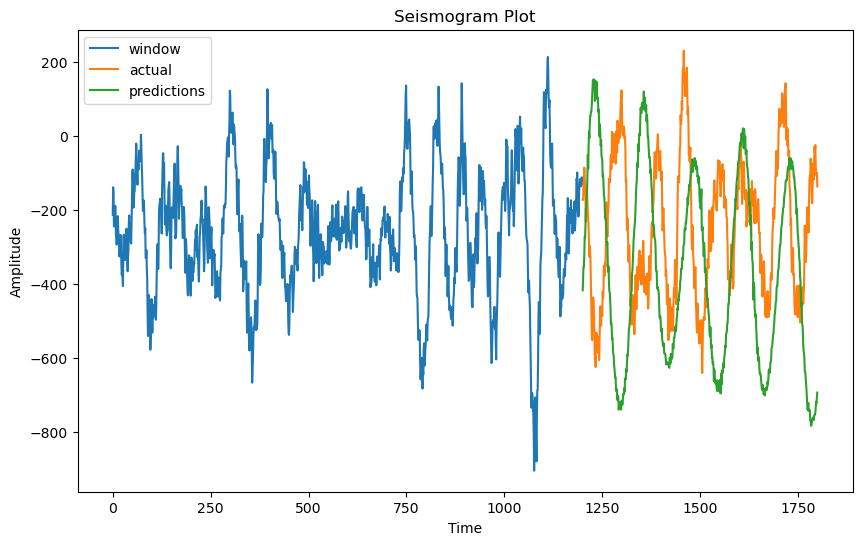

In [116]:
update_data()

In [158]:
def plot_prediction(trace, predictions):
    fig = plt.figure(figsize=(10, 6))
    
    # Calculate time points for predictions (assuming equal intervals)
    time_steps = len(trace.data)
    prediction_times = range(time_steps)  # Adjust this based on your prediction logic

    # Plot the seismogram data
    plt.plot(range(time_steps), trace.data, label='Seismogram Data')

    # Plot the predictions
    plt.plot(range(time_steps,time_steps+len(predictions[0])), predictions[0], label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Seismogram Plot')
    plt.legend()
    
    # Display the plot in Streamlit
    #streamlit.pyplot(fig)
    plt.show

In [124]:
len(trace.data)
end = trace.times("matplotlib")[-1]
end
len(trace.times("matplotlib"))

7482

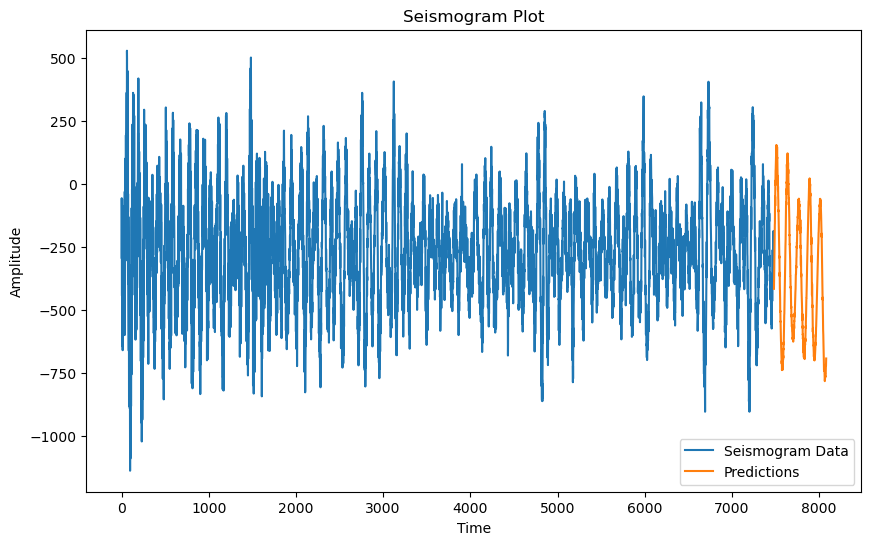

In [159]:
plot_prediction(trace, predictions)

In [39]:
window = scale_data(window, scaler)
print(window.shape)
window

(6000, 1)


array([[0.45105186],
       [0.45002723],
       [0.45054603],
       ...,
       [0.44779643],
       [0.4487562 ],
       [0.4488859 ]], dtype=float32)

In [161]:
selected_date = streamlit.date_input("Pick a date", datetime.date())

NameError: name 'streamlit' is not defined

In [162]:
 datetime.date()

TypeError: descriptor 'date' of 'datetime.datetime' object needs an argument